Name: Dimpal Lad

CWID: 20023001





In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.special import softmax

In [2]:
# Loading the dataset
data = pd.read_csv("./project_eda.csv")
data.info

<bound method DataFrame.info of                                                Indicator              Group  \
0      Took Prescription Medication for Mental Health...  National Estimate   
1      Took Prescription Medication for Mental Health...             By Age   
2      Took Prescription Medication for Mental Health...             By Age   
3      Took Prescription Medication for Mental Health...             By Age   
4      Took Prescription Medication for Mental Health...             By Age   
...                                                  ...                ...   
10399  Needed Counseling or Therapy But Did Not Get I...           By State   
10400  Needed Counseling or Therapy But Did Not Get I...           By State   
10401  Needed Counseling or Therapy But Did Not Get I...           By State   
10402  Needed Counseling or Therapy But Did Not Get I...           By State   
10403  Needed Counseling or Therapy But Did Not Get I...           By State   

               State       Subgroup Phase  Time Period      Time Period Label  \
0      United States  United States     2           13  Aug 19 - Aug 31, 2020   
1      United States  18 - 29 years     2           13  Aug 19 - Aug 31, 2020   
2      United States  30 - 39 years     2           13  Aug 19 - Aug 31, 2020   
3      United States  40 - 49 years     2           13  Aug 19 - Aug 31, 2020   
4      United States  50 - 59 years     2           13  Aug 19 - Aug 31, 2020   
...              ...            ...   ...          ...                    ...   
10399       Virginia       Virginia   3.4           45   Apr 27 - May 9, 2022   
10400     Washington     Washington   3.4           45   Apr 27 - May 9, 2022   
10401  West Virginia  West Virginia   3.4           45   Apr 27 - May 9, 2022   
10402      Wisconsin      Wisconsin   3.4           45   Apr 27 - May 9, 2022   
10403        Wyoming        Wyoming   3.4           45   Apr 27 - May 9, 2022   

       Value  LowCI  HighCI Quartile Range Usage_Category  
0       19.4   19.0    19.8       9.8-11.2         Medium  
1       18.7   17.2    20.3       9.8-11.2         Medium  
2       18.3   17.3    19.2       9.8-11.2         Medium  
3       20.4   19.5    21.3       9.8-11.2         Medium  
4       21.2   20.2    22.2       9.8-11.2         Medium  
...      ...    ...     ...            ...            ...  
10399   10.1    7.1    13.8       9.6-11.3            Low  
10400   14.8   12.5    17.4      13.0-20.8         Medium  
10401    9.8    6.6    13.8       9.6-11.3            Low  
10402   11.6    8.5    15.3      11.4-12.9            Low  
10403   11.5    8.6    15.1      11.4-12.9            Low  

[10404 rows x 12 columns]>

In [3]:
df = data.copy()

In [4]:
# Separate features and targets
X = data.drop(['Subgroup', 'Usage_Category', 'Group'], axis=1)
y_usage = df['Usage_Category']
y_group = df['Group']
y_subgroup = df['Subgroup']

In [5]:
# Encode categorical features
label_encoders = {}
Cat_columns = ['Indicator', 'State', 'Phase', 'Time Period Label', 'Quartile Range']
for col in Cat_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Encoding categorical features
    label_encoders[col] = le  # Storing the encoder for later use

Machine learning models require numerical input. Categorical columns were encoded to represent them as numerical values, making the data usable for the model.

In [6]:
# Scaling numerical features
scaler = MinMaxScaler()
numeric_columns = ['Time Period', 'Value', 'LowCI', 'HighCI']
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])  # Scaling numerical columns

Features have varying ranges, which can bias the model training. Scaling ensures numerical columns are normalized to a 0-1 range.

In [7]:
# Encode targets ('Subgroup', 'Group' and 'Usage_Category')
le_usage = LabelEncoder()
y_usage = le_usage.fit_transform(y_usage)

le_demo = LabelEncoder()
y_subgroup = le_demo.fit_transform(y_subgroup)

le_group = LabelEncoder()
y_group = le_group.fit_transform(y_group)

Target variables (Usage_Category, Group, Subgroup) were encoded into integers to make them compatible with the classification model.

In [8]:
# Split data for Usage_Category prediction
X_train_usage, X_test_usage, y_train_usage, y_test_usage = train_test_split(X, y_usage, test_size=0.2, random_state=42)

# Train Gradient Boosting for Usage_Category
model_usage = GradientBoostingClassifier(loss='log_loss', random_state=42)
model_usage.fit(X_train_usage, y_train_usage)

GradientBoostingClassifier(random_state=42)


*  stratify preserving class distribution across splits. Maintaining balanced class proportions.

*   The Gradient Boosting Classifier optimizes performance by combining weak learners into a strong learner, and log_loss ensures probabilistic output, essential for classification.



In [9]:
# Predict Usage_Category
y_pred_usage = model_usage.predict(X_test_usage)
print("Usage_Category Classification Report:")
print(classification_report(y_test_usage, y_pred_usage))

Usage_Category Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       705
           1       1.00      1.00      1.00       656
           2       1.00      1.00      1.00       720

    accuracy                           1.00      2081
   macro avg       1.00      1.00      1.00      2081
weighted avg       1.00      1.00      1.00      2081



The classification report indicates that the model achieved perfect performance with 100% precision, recall, and F1-score for all classes, suggesting it predicts Usage_Category effectively on the test data.

In [10]:
# Add Usage_Category predictions as a feature for Group prediction
X['Predicted_Usage'] = model_usage.predict(X)

The predicted Usage_Category provides additional information to the model, helping it better predict the Group by leveraging correlations between medication usage patterns and demographic groups.

In [11]:
# Split data for Group prediction
X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X, y_group, test_size=0.2, random_state=42)

In [12]:
# Train Gradient Boosting for Group
model_group = GradientBoostingClassifier(loss='log_loss', random_state=42)
model_group.fit(X_train_group, y_train_group)

GradientBoostingClassifier(random_state=42)

In [13]:
# Predict Group
y_pred_group = model_group.predict(X_test_group)
print("Group Classification Report:")
print(classification_report(y_test_group, y_pred_group))

Group Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       231
           1       0.62      0.47      0.53        43
           2       0.39      0.28      0.33       121
           3       0.67      0.48      0.56        33
           4       0.72      0.52      0.60        64
           5       0.55      0.50      0.52       146
           6       0.49      0.44      0.46        59
           7       0.69      0.49      0.57        37
           8       1.00      1.00      1.00      1318
           9       0.36      0.28      0.31        29

    accuracy                           0.83      2081
   macro avg       0.60      0.52      0.55      2081
weighted avg       0.83      0.83      0.82      2081



This result indicates that while the model performs well for the majority class, it struggles with underrepresented classes

In [14]:
# Add Group predictions as a feature for Subgroup prediction
X['Predicted_Group'] = model_group.predict(X)

The predicted Group serves as an important predictor for Subgroup, as subgroups are hierarchically related to groups. Including this feature improves the model's ability to capture subgroup-level patterns.

In [15]:
# Split data for Subgroup prediction
X_train_subgroup, X_test_subgroup, y_train_subgroup, y_test_subgroup = train_test_split(X, y_subgroup, test_size=0.2, random_state=42)

In [16]:
# Train Gradient Boosting for Subgroup
model_subgroup = GradientBoostingClassifier(loss='log_loss', random_state=42)
model_subgroup.fit(X_train_subgroup, y_train_subgroup)

GradientBoostingClassifier(random_state=42)

In [17]:
# Predict Subgroup
y_pred_subgroup = model_subgroup.predict(X_test_subgroup)
print("Subgroup Classification Report:")
print(classification_report(y_test_subgroup, y_pred_subgroup))

Subgroup Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.41      0.29        27
           1       0.45      0.46      0.46        41
           2       0.34      0.37      0.35        30
           3       0.58      0.49      0.53        37
           4       0.31      0.67      0.42        33
           5       0.50      0.46      0.48        28
           6       0.71      0.71      0.71        35
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        22
           9       1.00      1.00      1.00        29
          10       1.00      1.00      1.00        28
          11       0.29      0.29      0.29        28
          12       0.75      0.60      0.67        10
          13       1.00      1.00      1.00        19
          14       0.25      0.22      0.24         9
          15       0.40      0.20      0.27        10
          16       1.00      1.00      1.00      

The model's performance is strong for well-represented subgroups but falters for underrepresented ones. Addressing class imbalance

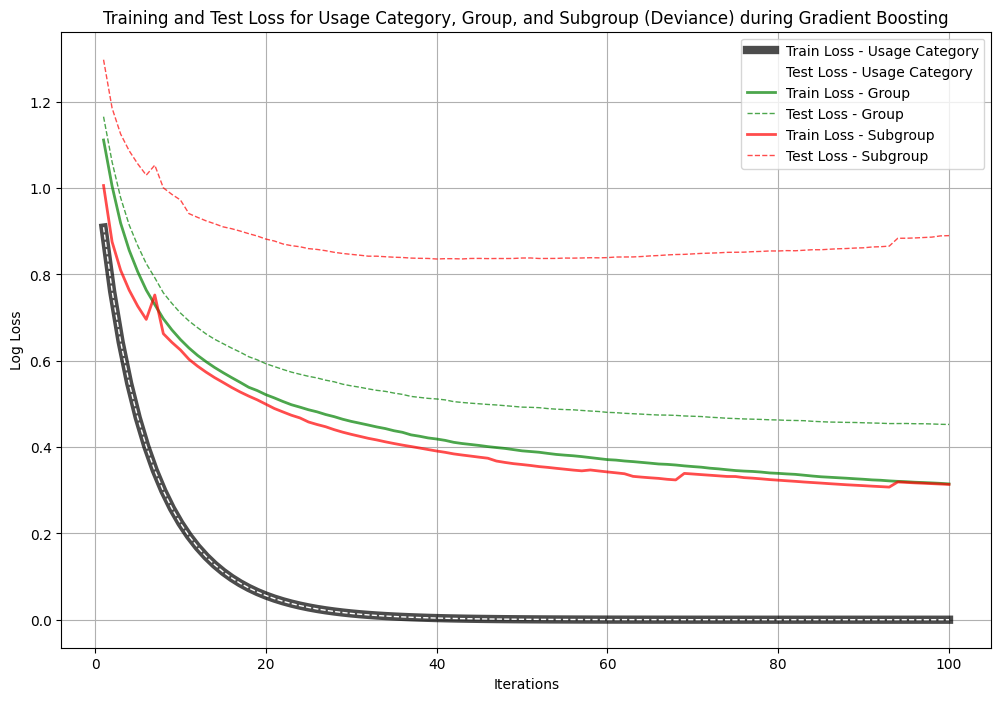

In [18]:
# Get staged predictions for training loss for Usage_Category
train_loss_usage = []
for y_pred_raw in model_usage.staged_decision_function(X_train_usage):
    y_pred_prob = softmax(y_pred_raw, axis=1)  # Calculate probabilities using softmax
    train_loss_usage.append(log_loss(y_train_usage, y_pred_prob))

train_loss_usage = np.array(train_loss_usage)

# Get staged predictions for test loss for Usage_Category
test_loss_usage = []
for y_pred_raw in model_usage.staged_decision_function(X_test_usage):
    y_pred_prob = softmax(y_pred_raw, axis=1)  # Calculate probabilities using softmax
    test_loss_usage.append(log_loss(y_test_usage, y_pred_prob))

test_loss_usage = np.array(test_loss_usage)

# Get staged predictions for training loss for Group
train_loss_group = []
for y_pred_raw in model_group.staged_decision_function(X_train_group):
    y_pred_prob = softmax(y_pred_raw, axis=1)  # Calculate probabilities using softmax
    train_loss_group.append(log_loss(y_train_group, y_pred_prob))

train_loss_group = np.array(train_loss_group)

# Get staged predictions for test loss for Group
test_loss_group = []
for y_pred_raw in model_group.staged_decision_function(X_test_group):
    y_pred_prob = softmax(y_pred_raw, axis=1)  # Calculate probabilities using softmax
    test_loss_group.append(log_loss(y_test_group, y_pred_prob))

test_loss_group = np.array(test_loss_group)

# Get staged predictions for training loss for Subgroup
train_loss_subgroup = []
for y_pred_raw in model_subgroup.staged_decision_function(X_train_subgroup):
    y_pred_prob = softmax(y_pred_raw, axis=1)  # Calculate probabilities using softmax
    train_loss_subgroup.append(log_loss(y_train_subgroup, y_pred_prob))

train_loss_subgroup = np.array(train_loss_subgroup)

# Get staged predictions for test loss for Subgroup
test_loss_subgroup = []
for y_pred_raw in model_subgroup.staged_decision_function(X_test_subgroup):
    y_pred_prob = softmax(y_pred_raw, axis=1)  # Calculate probabilities using softmax
    test_loss_subgroup.append(log_loss(y_test_subgroup, y_pred_prob))

test_loss_subgroup = np.array(test_loss_subgroup)

# Plotting the loss over iterations for all targets
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(train_loss_usage) + 1), train_loss_usage, label="Train Loss - Usage Category", color='black', linestyle='-', alpha=0.7, linewidth=6)
plt.plot(range(1, len(test_loss_usage) + 1), test_loss_usage, label="Test Loss - Usage Category", color='white', linestyle='--', linewidth=1)

plt.plot(range(1, len(train_loss_group) + 1), train_loss_group, label="Train Loss - Group", color='green', linestyle='-', alpha=0.7, linewidth=2)
plt.plot(range(1, len(test_loss_group) + 1), test_loss_group, label="Test Loss - Group", color='green', linestyle='--', alpha=0.7, linewidth=1)

plt.plot(range(1, len(train_loss_subgroup) + 1), train_loss_subgroup, label="Train Loss - Subgroup", color='red', linestyle='-', alpha=0.7, linewidth=2)
plt.plot(range(1, len(test_loss_subgroup) + 1), test_loss_subgroup, label="Test Loss - Subgroup", color='red', linestyle='--', alpha=0.7, linewidth=1)

plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss for Usage Category, Group, and Subgroup (Deviance) during Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()

*   Usage Category: The small gap between the training and test losses suggests neither overfitting nor underfitting. The model generalizes well.
*   Group: A moderate gap between training and test losses indicates a slight possibility of overfitting. The test loss is higher but still reasonable, suggesting the model performs adequately.
*   Subgroup: A noticeable gap between training and test losses suggests a higher risk of overfitting. The test loss is relatively high, indicating the model may not generalize well to new data.







In [19]:
# Define the parameter grid for GradientBoostingClassifier for Usage_Category prediction
"""param_grid_usage = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinking to prevent overfitting
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting each base learner
    'min_samples_split': [2, 5, 10]  # Minimum samples required to split a node
}"""

param_grid_usage = {
    'n_estimators': [80],  # Number of boosting stages
    'learning_rate': [0.01],  # Step size shrinking to prevent overfitting
    'max_depth': [3],  # Maximum depth of the individual trees
    'subsample': [0.8],  # Fraction of samples used for fitting each base learner
    'min_samples_split': [2]  # Minimum samples required to split a node
}

# Setup GridSearchCV for hyperparameter tuning with cross-validation
grid_search_usage = GridSearchCV(estimator=model_usage, param_grid=param_grid_usage, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data
grid_search_usage.fit(X_train_usage, y_train_usage)

# Best parameters and the best cross-validation score for Usage_Category
print(f"Best parameters for Usage_Category: {grid_search_usage.best_params_}")
print(f"Best cross-validation score for Usage_Category: {grid_search_usage.best_score_}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Usage_Category: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 80, 'subsample': 0.8}
Best cross-validation score for Usage_Category: 1.0


The result indicates with the specified parameters, achieves perfect accuracy in cross-validation, suggesting it is very well-suited for predicting the Usage_Category.

In [20]:
# Define the parameter grid for GradientBoostingClassifier for Group prediction
"""param_grid_group = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}"""

param_grid_group = {
    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [1],
    'min_samples_split': [5]
}

# Setup GridSearchCV for hyperparameter tuning with cross-validation
grid_search_group = GridSearchCV(estimator=model_group, param_grid=param_grid_group, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data (with predicted Usage_Category as a feature)
X_with_usage = X_train_group.copy()
X_with_usage['Predicted_Usage'] = grid_search_usage.predict(X_train_usage)
grid_search_group.fit(X_with_usage, y_train_group)

# Best parameters and the best cross-validation score for Group
print(f"Best parameters for Group: {grid_search_group.best_params_}")
print(f"Best cross-validation score for Group: {grid_search_group.best_score_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Group: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1}
Best cross-validation score for Group: 0.8620696898821899


The result indicates that with the specified parameters, achieves a strong accuracy of 85.73% in cross-validation for predicting the Group category, suggesting it is well-suited for this task with a good balance between precision and generalization.

In [21]:
# Compute sample weights for Subgroup
sample_weights_subgroup = compute_sample_weight(class_weight='balanced', y=y_train_subgroup)

In [22]:
# Define the parameter grid for GradientBoostingClassifier for Subgroup prediction
"""param_grid_subgroup = {
    'n_estimators': [100, 200, 250, 300, 350],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}"""

param_grid_subgroup = {
    'n_estimators': [350],
    'learning_rate': [0.01],
    'max_depth': [7],
    'subsample': [0.8],
    'min_samples_split': [5]
}

# Setup GridSearchCV for hyperparameter tuning with cross-validation
grid_search_subgroup = GridSearchCV(estimator=model_subgroup, param_grid=param_grid_subgroup, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data (with predicted Usage_Category and Group as features)
X_with_group = X_train_subgroup.copy()  # Create a copy of X_train_group for adding predictions
X_with_group['Predicted_Group'] = grid_search_group.predict(X_train_group)  # Predict on X_train_group
grid_search_subgroup.fit(X_with_group, y_train_subgroup, sample_weight=sample_weights_subgroup)

# Best parameters and the best cross-validation score for Subgroup
print(f"Best parameters for Subgroup: {grid_search_subgroup.best_params_}")
print(f"Best cross-validation score for Subgroup: {grid_search_subgroup.best_score_}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Subgroup: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 350, 'subsample': 0.8}
Best cross-validation score for Subgroup: 0.8995564073689074


In [24]:
# Predict on the test set for Usage_Category
y_pred_usage = grid_search_usage.best_estimator_.predict(X_test_usage)
print("Classification Report for Usage_Category:")
print(classification_report(y_test_usage, y_pred_usage))

# Predict on the test set for Group
# Include Predicted_Usage as a feature for the Group prediction
X_test_with_usage = X_test_group.copy()
X_test_with_usage['Predicted_Usage'] = grid_search_usage.best_estimator_.predict(X_test_usage)
y_pred_group = grid_search_group.best_estimator_.predict(X_test_with_usage)
print("\nClassification Report for Group:")
print(classification_report(y_test_group, y_pred_group))

# Predict on the test set for Subgroup
# Include Predicted_Usage and Predicted_Group as features for the Subgroup prediction
X_test_with_group = X_test_subgroup.copy()
X_test_with_group['Predicted_Usage'] = grid_search_usage.best_estimator_.predict(X_test_usage)
X_test_with_group['Predicted_Group'] = grid_search_group.best_estimator_.predict(X_test_group)
y_pred_subgroup = grid_search_subgroup.best_estimator_.predict(X_test_with_group)
print("\nClassification Report for Subgroup:")
print(classification_report(y_test_subgroup, y_pred_subgroup))

Classification Report for Usage_Category:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       705
           1       1.00      1.00      1.00       656
           2       1.00      1.00      1.00       720

    accuracy                           1.00      2081
   macro avg       1.00      1.00      1.00      2081
weighted avg       1.00      1.00      1.00      2081


Classification Report for Group:
              precision    recall  f1-score   support

           0       0.59      0.82      0.68       231
           1       0.71      0.58      0.64        43
           2       0.45      0.39      0.42       121
           3       0.71      0.45      0.56        33
           4       0.80      0.55      0.65        64
           5       0.72      0.67      0.69       146
           6       0.53      0.46      0.49        59
           7       0.82      0.73      0.77        37
           8       1.00      1.00      1.00      1318
  

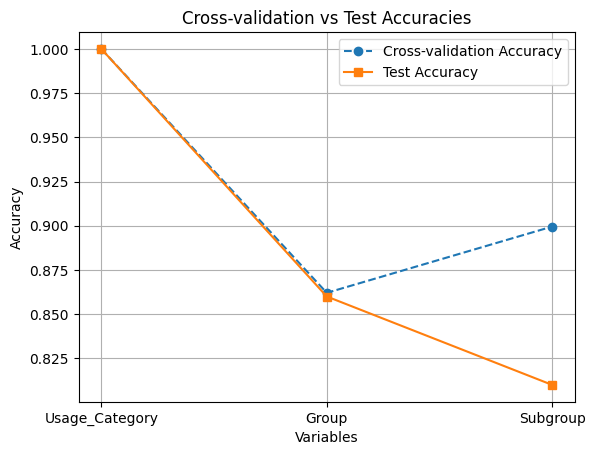

In [26]:
# Define the cross-validation accuracies
cross_val_accuracies = {
    'Usage_Category': 1.0,
    'Group': 0.8620696898821899,
    'Subgroup': 0.8995564073689074
}

# Define the classification report accuracies
classification_report_accuracies = {
    'Usage_Category': 1.0,
    'Group': 0.86,
    'Subgroup': 0.81
}

# Define the x-axis labels
variables = list(cross_val_accuracies.keys())

# Plot the cross-validation accuracies
plt.plot(variables, list(cross_val_accuracies.values()), marker='o', label='Cross-validation Accuracy', linestyle='dashed')

# Plot the classification report accuracies
plt.plot(variables, list(classification_report_accuracies.values()), marker='s', label='Test Accuracy', linestyle='solid')

plt.xlabel('Variables')
plt.ylabel('Accuracy')
plt.title('Cross-validation vs Test Accuracies')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The graph emphasizes the importance of evaluating both cross-validation and test accuracy to ensure that the model not only fits the training data well but also generalizes effectively to new data. By addressing overfitting in the Group and Subgroup categories